In [14]:
import numpy as np
import matplotlib.pyplot as plt
import gillespy2
import pickle
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import random
from scipy.special import factorial

In [15]:
#repressor system

def ToggleSwitch(parameter_values=None):
    # Initialize the model
    model = gillespy2.Model(name="toggle_switch")

    # Define parameters
    beta1 = gillespy2.Parameter(name='beta1', expression=10)
    a = gillespy2.Parameter(name='a', expression=50)
    n1 = gillespy2.Parameter(name='n1', expression=1.0)
    beta2 = gillespy2.Parameter(name='beta2', expression=0.0)
    k2 = gillespy2.Parameter(name='k2', expression=1.0)
    n2 = gillespy2.Parameter(name='n2', expression=1.0)
    alpha = gillespy2.Parameter(name='alpha', expression=0.01)
     
    model.add_parameter([beta1, a, n1, beta2, k2, n2, alpha])
    # Define molecular species
    x = gillespy2.Species(name='x', initial_value=200)
   
    model.add_species([x])

    # Define reactions
    cu = gillespy2.Reaction(name="r1", reactants={}, products={x: 1},
                            propensity_function="beta1*(pow(a,n1)/(pow(a,n1)+pow(x,n1)))")#degradation
    cv = gillespy2.Reaction(name="r2", reactants={x:1}, products={},
                            propensity_function="alpha*x")
    #du = gillespy2.Reaction(name="r3", reactants={}, products={x:1},
                            #propensity_function="beta2*(pow(x,n2)/(pow(k2,n2)+pow(x,n2)))")
    
    model.add_reaction([cu, cv])

    tspan = gillespy2.TimeSpan.linspace(10000)
    model.timespan(tspan)

    return model


In [16]:
model = ToggleSwitch()
s_results = model.run()
ssa_results = model.run(algorithm="SSA")
tau_results = model.run(algorithm="Tau-Leaping")



In [17]:
def CLE(beta1, beta2, a, n1, k2, n2, alpha, dt):
    x = [x0]
    for i in range(len(t) - 1):
        dxi = np.random.normal(0, 1, 3) 
        x_curr = x[-1]
        
        

        F = (
            beta1 * (pow(a, n1) / (pow(a, n1) + pow(x_curr, n1))) +
            beta2 * (pow(x_curr, n2) / (pow(k2, n2) + pow(x_curr, n2))) -
            alpha * x_curr)
        
        G = (
            np.sqrt(beta1 * (pow(a, n1) / (pow(a, n1) + pow(x_curr, n1)))) * dxi[0] +
            np.sqrt(beta2 * (pow(x_curr, n2) / (pow(k2, n2) + pow(x_curr, n2)))) * dxi[1] +
            np.sqrt(alpha * x_curr) * dxi[2])
        
        x_next = x_curr + dt * F + np.sqrt(dt) * G

        x = np.hstack([x, x_next])
    return x


In [18]:
beta1=10
a=50
n1=1
beta2=0.0
k2=1
n2=1
alpha=0.01
dt = 10000 #increment

x0=200 #initial concentration
cont_act = [beta1,a,n1]
cont_rep = [beta2,k2,n2]

In [19]:
x_ssa = ssa_results['x']
t_ssa = ssa_results['time']

x_tau = tau_results['x']
t_tau = tau_results['time']

t = ssa_results['time']
dt = t[1] - t[0]
x_cle = CLE(beta1, beta2, a, n1, k2, n2, alpha, dt)


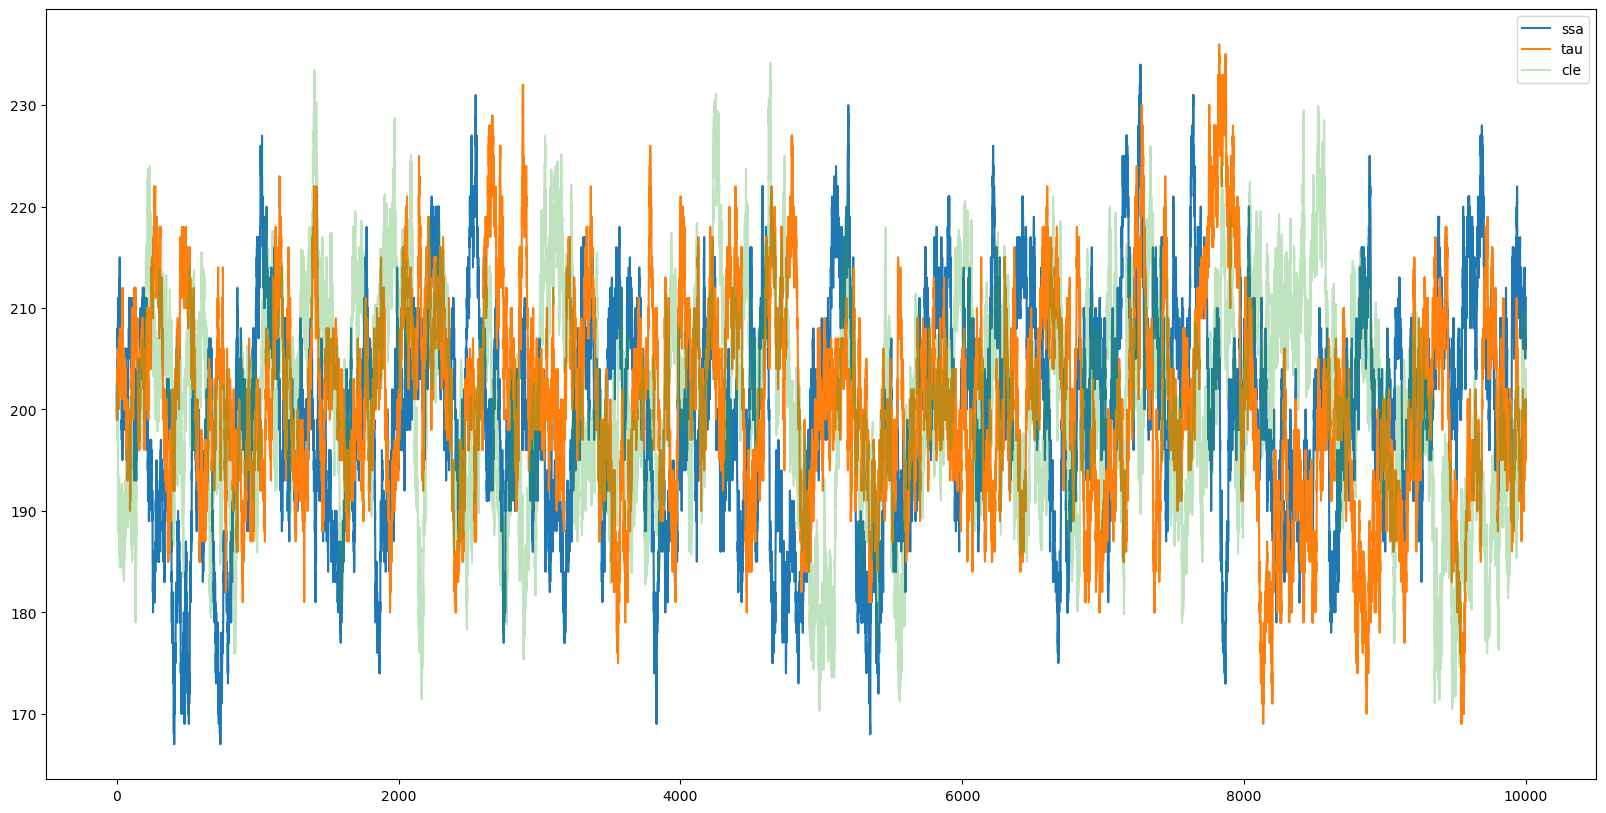

In [20]:
plt.figure(figsize = (20,10))
plt.plot(t_ssa, x_ssa,label = 'ssa')
plt.plot(t_tau, x_tau,label = 'tau')
plt.plot(t,x_cle,alpha = 0.3,label = 'cle')



plt.legend()

Text(0.5, 1.0, 'cle_mean $\\mu$ = 200.728, $\\sigma$ = 10.186')

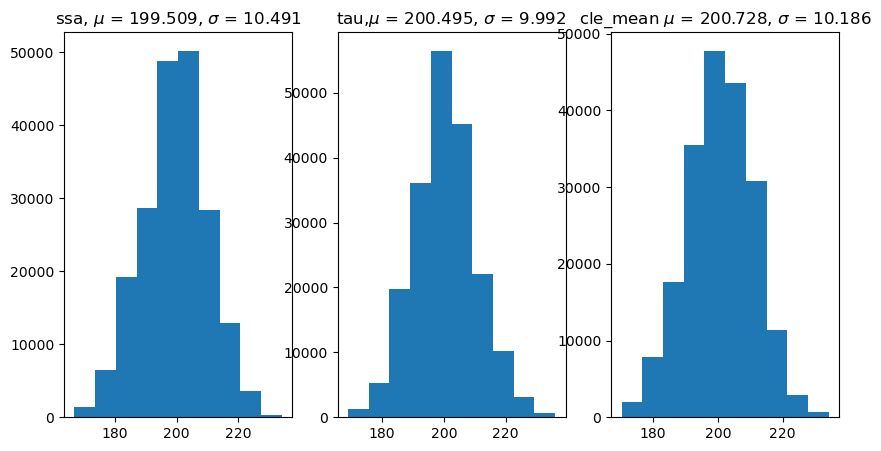

In [21]:
fig, axs = plt.subplots(1,3,figsize = (10,5))
axs[0].hist(x_ssa)
axs[0].set_title('ssa, $\mu$ = %s, $\sigma$ = %s' % (np.round(np.mean(x_ssa),3),np.round(np.std(x_ssa),3)))
axs[1].hist(x_tau)
axs[1].set_title('tau,$\mu$ = %s, $\sigma$ = %s' % (np.round(np.mean(x_tau),3),np.round(np.std(x_tau),3)))
axs[2].hist(x_cle)
axs[2].set_title('cle_mean $\mu$ = %s, $\sigma$ = %s' % (np.round(np.mean(x_cle),3),np.round(np.std(x_cle),3)))

In [23]:
with open('data_simulation.pickle', 'wb') as f:
    
    pickle.dump([x_ssa,t,cont_act,cont_rep,alpha], f)